In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

from peak import get_peak_model
from tracr.haiku_to_pytorch import haiku_to_pytorch, apply
from trainedmodels import *

from dataloaders import makePalindromeDataLoader
import matplotlib.pyplot as plt

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 
init_model = get_peak_model()
base_model = haiku_to_pytorch(init_model)

# Get vocab from the encoder's encoding_map
token_to_idx = init_model.input_encoder.encoding_map
vocab_list = list(token_to_idx.keys())
vocab_size = init_model.input_encoder.vocab_size
d_model = base_model.layers[0].attn.d_model

# Get actual max position from the Haiku model
max_pos = init_model.params['pos_embed']['embeddings'].shape[0]

In [3]:
class TracrWithEmbeddings(nn.Module):
    def __init__(self, base_model, vocab_size, d_model, max_pos, token_to_idx, haiku_model):
        super().__init__()
        self.base_model = base_model
        self.token_to_idx = token_to_idx
        self.haiku_model = haiku_model
        
        # Create learnable embedding layers with correct sizes
        self.token_embed = nn.Embedding(vocab_size, d_model, dtype=torch.float64)
        self.pos_embed = nn.Embedding(max_pos, d_model, dtype=torch.float64)
        
        # Initialize with Haiku weights
        with torch.no_grad():
            token_emb_weights = torch.tensor(
                np.array(haiku_model.params['token_embed']['embeddings']),
                dtype=torch.float64
            )
            self.token_embed.weight.copy_(token_emb_weights)
            
            pos_emb_weights = torch.tensor(
                np.array(haiku_model.params['pos_embed']['embeddings']),
                dtype=torch.float64
            )
            self.pos_embed.weight.copy_(pos_emb_weights)
    
    def forward(self, x):
        # x is list of token sequences: [['BOS', 'a', 'b'], ...]
        x = [x]
        # Convert to indices
        batch_indices = []
        for seq in x:
            indices = [self.token_to_idx[token] for token in seq]
            batch_indices.append(indices)
        
        # Convert to tensor
        x_indices = torch.tensor(batch_indices, dtype=torch.long, device=self.token_embed.weight.device)
        B, T = x_indices.shape
        
        # Get embeddings (these have gradients!)
        tok_emb = self.token_embed(x_indices)
        pos_emb = self.pos_embed(torch.arange(T, device=x_indices.device))
        x = tok_emb + pos_emb
        
        # Apply transformer layers from base model
        for layer in self.base_model.layers:
            x = layer(x)
        
        return x

# Add classification head wrapper
class TracrClassifier(nn.Module):
    def __init__(self, transformer, d_model, num_classes=2):
        super().__init__()
        self.transformer = transformer
        self.classifier = nn.Linear(d_model, num_classes, dtype=torch.float64)
        
        # Initialize classifier with small weights to prevent instability
        with torch.no_grad():
            self.classifier.weight.normal_(0, 0.01)
            self.classifier.bias.zero_()
    
    def forward(self, x):
        hidden = self.transformer(x)  # (batch, seq_len, d_model)
        pooled = hidden[:, -1, :]  # Use last token (batch, d_model)
        logits = self.classifier(pooled)  # (batch, num_classes)
        return logits

In [3]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, max_pos, token_to_idx):
        super().__init__()
        self.token_to_idx = token_to_idx
        
        # Create learnable embedding layers with correct sizes
        self.token_embed = nn.Embedding(vocab_size, d_model, dtype=torch.float64)
        self.pos_embed = nn.Embedding(max_pos, d_model, dtype=torch.float64)

        self.transformer = nn.TransformerEncoderLayer(d_model, 1 , dtype=torch.float64)
        self.feedforward = nn.Linear(d_model, d_model , dtype=torch.float64)
        self.out = nn.Linear(d_model, 2 , dtype=torch.float64)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = [x]
        # Convert to indices
        batch_indices = []
        for seq in x:
            indices = [self.token_to_idx[token] for token in seq]
            batch_indices.append(indices)
        
        # Convert to tensor
        x_indices = torch.tensor(batch_indices, dtype=torch.long, device=self.token_embed.weight.device)
        B, T = x_indices.shape
        # Get embeddings (these have gradients!)
        tok_emb = self.token_embed(x_indices)
        pos_emb = self.pos_embed(torch.arange(T, device=x_indices.device))
        x = tok_emb + pos_emb
        x = self.transformer(x)
        x = self.feedforward(x)
        x = self.out(x)
        x = self.softmax(x)

        return x

In [4]:
model = Transformer(vocab_size, d_model, max_pos, token_to_idx)

In [4]:
# Create model with classification head
base_transformer = TracrWithEmbeddings(base_model, vocab_size, d_model, max_pos, token_to_idx, init_model)
model = TracrClassifier(base_transformer, d_model, num_classes=2)

In [5]:
# Enable gradients
for param in model.parameters():
    param.requires_grad = True

model = model.to(DEVICE)

# Dataset
class PeakDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, seq_len, num_samples):
        self.vocab = vocab
        self.seq_len = seq_len
        self.num_samples = num_samples
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        seq = [np.random.choice(self.vocab) for _ in range(self.seq_len)]
        seq = ["BOS"] + seq

        peaks = ["BOS"]
        for i in range(1, len(seq)):
            if i == 1 or i == len(seq) - 1:
                if len(seq) == 2:
                    peaks.append(False)
                elif i == 1:
                    peaks.append(seq[i] > seq[i + 1])
                elif i == len(seq) - 1:
                    peaks.append(seq[i] > seq[i - 1])
            else:
                peaks.append(seq[i] > seq[i - 1] and seq[i] > seq[i + 1])
        # Label = 1 if there is any peak, else 0
        labels = []

        for val in peaks:
            if val == np.True_:
                labels.append([0.0, 1.0])
            else:
                labels.append([1.0, 0.0])

        return seq, torch.tensor([labels])

def custom_collate(batch):
    """Keep sequences as lists, batch only labels"""
    sequences, labels = zip(*batch)
    return sequences, torch.tensor(labels, dtype=torch.long)

def identify_collate(batch):
    return batch

# Create dataset and loader
vocab = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
data = PeakDataset(vocab=vocab, seq_len=5, num_samples=250)
loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True, collate_fn=identify_collate)

In [6]:
def evaluate(model, batch):
    batch = batch[0]
    sequences, labels = batch  
    labels = labels.to(DEVICE)
    
    # Get logits from model
    logits = model(sequences)  # (batch, 2)
    
    # Check for NaN/inf in logits before computing loss
    if torch.isnan(logits).any() or torch.isinf(logits).any():
        print("NaN/Inf in logits!")
        print("Logits stats - min:", logits.min().item(), "max:", logits.max().item())
        return torch.tensor(float('inf'), device=DEVICE)
    
    # Compute proper cross-entropy loss
    loss = F.cross_entropy(logits, labels)
    
    # Debug NaN if it occurs
    if torch.isnan(loss):
        print("NaN in loss!")
        print("Logits:", logits[:5])
        print("Labels:", labels[:5])
    
    return loss

In [10]:
model, results = train_model(loader, None, 50, evaluate, loader, pytorch_model=model, training_params=dict(lr=1e-3, weight_decay=1e-5, betas=(0.9,0.999), eps=1e-9), llc_dict=dict(lr=3e-3, loc=5, num_chains=1, num_draws=100))

Initial training loss = 5.2748


/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/utils.py:88: UserWarning: default nbeta is undefined for batch_size * grad_accum_steps == 1, falling back to default value of 1
  warnings.warn(
/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:285: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinte

Initial test loss = 5.3168


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 43.42it/s]
/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/slt/llc.py:189: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  self.llc_stds = self.llcs.std(dim=0)


0.23
Epoch 1: training loss = 5.3194
Epoch 1: test loss = 5.3166


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 46.11it/s]


-0.14
Epoch 2: training loss = 5.2824
Epoch 2: test loss = 5.2674


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 46.04it/s]


-0.02
Epoch 3: training loss = 5.2698
Epoch 3: test loss = 5.2041


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 46.28it/s]


0.38
Epoch 4: training loss = 5.3164
Epoch 4: test loss = 5.2688


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 42.79it/s]


0.17
Epoch 5: training loss = 5.3128
Epoch 5: test loss = 5.2362


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 49.14it/s]


0.54
Epoch 6: training loss = 5.2535
Epoch 6: test loss = 5.2510


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 46.25it/s]


0.64
Epoch 7: training loss = 5.3123
Epoch 7: test loss = 5.2280


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 45.12it/s]


0.03
Epoch 8: training loss = 5.2222
Epoch 8: test loss = 5.2131


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 47.21it/s]


-0.04
Epoch 9: training loss = 5.2249
Epoch 9: test loss = 5.3734


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 44.74it/s]


0.54
Epoch 10: training loss = 5.2787
Epoch 10: test loss = 5.2756


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 51.34it/s]


0.55
Epoch 11: training loss = 5.2328
Epoch 11: test loss = 5.2078


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 60.02it/s]


0.47
Epoch 12: training loss = 5.2343
Epoch 12: test loss = 5.1743


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 65.84it/s]


-0.16
Epoch 13: training loss = 5.2083
Epoch 13: test loss = 5.2533


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 90.98it/s]


-0.0
Epoch 14: training loss = 5.2365
Epoch 14: test loss = 5.2495


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 55.44it/s]


0.28
Epoch 15: training loss = 5.2045
Epoch 15: test loss = 5.1772


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 60.64it/s]


-0.05
Epoch 16: training loss = 5.2118
Epoch 16: test loss = 5.1423


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 62.81it/s]


-0.05
Epoch 17: training loss = 5.1826
Epoch 17: test loss = 5.1727


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 63.05it/s]


0.46
Epoch 18: training loss = 5.1790
Epoch 18: test loss = 5.1730


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 62.45it/s]


0.29
Epoch 19: training loss = 5.1719
Epoch 19: test loss = 5.1689


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 61.54it/s]


0.45
Epoch 20: training loss = 5.1679
Epoch 20: test loss = 5.1502


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 65.05it/s]


-0.16
Epoch 21: training loss = 5.1546
Epoch 21: test loss = 5.1663


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 61.47it/s]


-0.11
Epoch 22: training loss = 5.1482
Epoch 22: test loss = 5.1196


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 63.96it/s]


-0.17
Epoch 23: training loss = 5.1219
Epoch 23: test loss = 5.0987


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 61.59it/s]


0.11
Epoch 24: training loss = 5.1331
Epoch 24: test loss = 5.1326


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 62.41it/s]


0.23
Epoch 25: training loss = 5.1503
Epoch 25: test loss = 5.1588


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 59.87it/s]


0.24
Epoch 26: training loss = 5.1704
Epoch 26: test loss = 5.1673


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 60.24it/s]


0.56
Epoch 27: training loss = 5.1367
Epoch 27: test loss = 5.1176


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 63.91it/s]


-0.11
Epoch 28: training loss = 5.1181
Epoch 28: test loss = 5.1224


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 64.06it/s]


0.24
Epoch 29: training loss = 5.1739
Epoch 29: test loss = 5.1473


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 65.92it/s]


0.29
Epoch 30: training loss = 5.1555
Epoch 30: test loss = 5.1345


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 65.89it/s]


0.31
Epoch 31: training loss = 5.1683
Epoch 31: test loss = 5.1960


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 68.66it/s]


0.31
Epoch 32: training loss = 5.1472
Epoch 32: test loss = 5.1360


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 65.91it/s]


0.5
Epoch 33: training loss = 5.1494
Epoch 33: test loss = 5.1626


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 64.03it/s]


0.53
Epoch 34: training loss = 5.1661
Epoch 34: test loss = 5.1456


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 64.83it/s]


0.29
Epoch 35: training loss = 5.1441
Epoch 35: test loss = 5.1318


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 64.25it/s]


0.4
Epoch 36: training loss = 5.1171
Epoch 36: test loss = 5.1043


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 63.29it/s]


0.22
Epoch 37: training loss = 5.1144
Epoch 37: test loss = 5.0854


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 61.97it/s]


-0.07
Epoch 38: training loss = 5.1143
Epoch 38: test loss = 5.0889


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 63.25it/s]


0.15
Epoch 39: training loss = 5.0906
Epoch 39: test loss = 5.1068


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 63.43it/s]


-0.08
Epoch 40: training loss = 5.1381
Epoch 40: test loss = 5.1207


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 65.00it/s]


-0.19
Epoch 41: training loss = 5.1210
Epoch 41: test loss = 5.0986


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 64.75it/s]


0.33
Epoch 42: training loss = 5.0956
Epoch 42: test loss = 5.1092


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 62.51it/s]


-0.25
Epoch 43: training loss = 5.1604
Epoch 43: test loss = 5.1358


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 62.66it/s]


0.61
Epoch 44: training loss = 5.1256
Epoch 44: test loss = 5.1237


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 63.60it/s]


-0.14
Epoch 45: training loss = 5.1157
Epoch 45: test loss = 5.0809


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 95.31it/s]


0.31
Epoch 46: training loss = 5.1265
Epoch 46: test loss = 5.0929


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 64.10it/s]


0.43
Epoch 47: training loss = 5.1069
Epoch 47: test loss = 5.1193


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 59.98it/s]


0.35
Epoch 48: training loss = 5.1181
Epoch 48: test loss = 5.0967


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 61.13it/s]


0.54
Epoch 49: training loss = 5.1470
Epoch 49: test loss = 5.0914


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 59.91it/s]


-0.03
Epoch 50: training loss = 5.1212
Epoch 50: test loss = 5.0974


Chain 0: 100%|██████████| 100/100 [00:01<00:00, 60.40it/s]

0.24


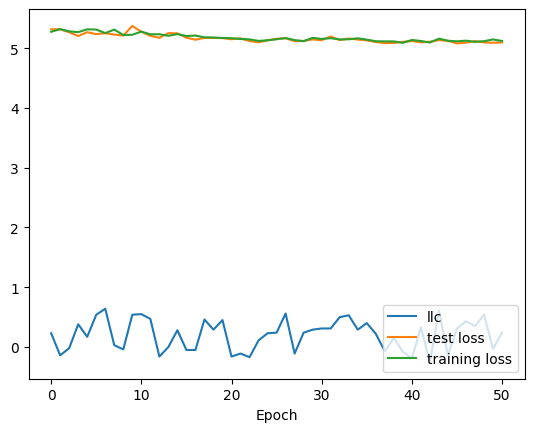

In [11]:
x = range(0, len(results['llc']))
plt.plot(x, results['llc'], label='llc')
plt.plot(x, results['test_loss'], label='test loss')
plt.plot(x, results['train_loss'], label='training loss')
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.show()